In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

import timm
from torchvision import transforms

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
CFG = {
          "epochs": 20,
          "img_size": 256,
          "model_name": "resnet50d",
          "num_classes": 15587,
          "train_batch_size": 64,
          "valid_batch_size": 64,
          "lr": 1e-3,
          "num_workers": 8,
          "min_lr": 1e-6,
#           "T_max": 500,
#           "weight_decay": 1e-6,
          "folder": "test",
          "n_fold": 5,
          "fold_number": 0,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
#           # ArcFace Hyperparameters
#           "s": 30.0, 
#           "m": 0.50,
#           "ls_eps": 0.0,
#           "easy_margin": False
          }

In [4]:
PATH = '/home/haohe/kaggle/whale'
train_data = PATH + '/data/img_256/train_images-256-256/train_images-256-256'
test_data = PATH + '/data/img_256/test_images-256-256/test_images-256-256'
df_train = pd.read_csv(PATH + '/data/raw_data/train.csv')
df_test = pd.read_csv(PATH + '/data/raw_data/sample_submission.csv')

In [5]:
gkf = GroupKFold(n_splits=5)

df_train.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gkf.split(X=df_train.index, y=df_train['individual_id'], groups=df_train['image'])):
    df_train.loc[df_train.iloc[val_index].index, 'fold'] = fold_number

encoder = LabelEncoder()
df_train['label'] = encoder.fit_transform(df_train['individual_id'])

In [6]:
class WhaleDataset(Dataset):
    def __init__(self,path,df,transforms=None):
        super().__init__()
        self.path = path
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        fname, label = self.df.iloc[idx]['image'], self.df.iloc[idx]['label']
        image = cv2.imread(f'{self.path}/{fname}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            aug = self.transforms(
                image = image,
            )
            image = aug['image']
        return image, torch.tensor(label, dtype=torch.long)
    
class DatasetSubmission(WhaleDataset):
    def __getitem__(self,idx):
        fname = self.df.iloc[idx]['image']
        image = cv2.imread(f'{self.path}/{fname}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            aug = self.transforms(
                image = image,
            )
            image = aug['image']
        return image, fname

In [7]:
def get_train_transform():
    return A.Compose([
        A.Resize(CFG['img_size'], CFG['img_size']),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
        A.Blur(blur_limit=3,p=0.2),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)

def get_valid_transform():
    return A.Compose([
        A.Resize(CFG['img_size'], CFG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)

In [8]:
validation_dataset = WhaleDataset(
    path = train_data,
    df = df_train[df_train['fold'] == CFG['fold_number']],
    transforms=get_valid_transform(),
)

test_dataset = DatasetSubmission(
    path = test_data,
    df = df_test,
    transforms=get_valid_transform(),
)

In [9]:
def denormalize(x:torch.tensor):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    return x * std[...,None,None] + mean[...,None,None]

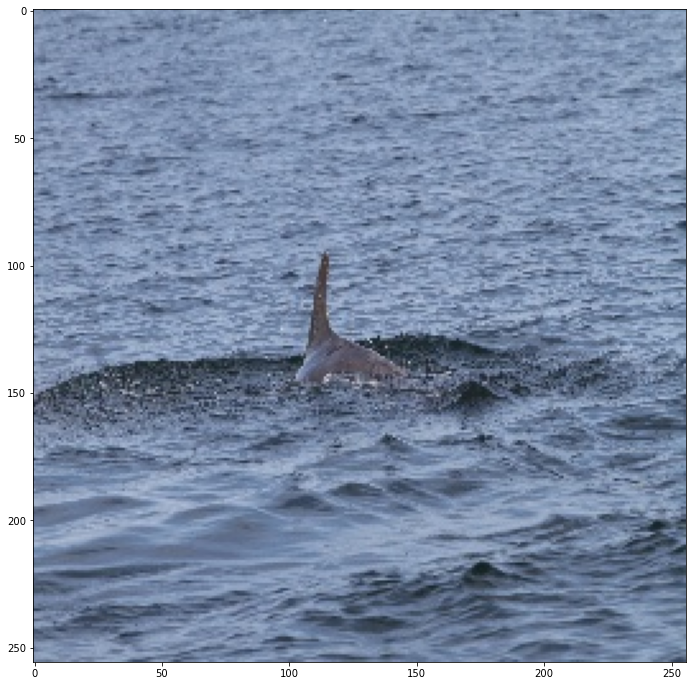

In [11]:
image, target = test_dataset[6]

image = denormalize(image)

image = image.permute(1,2,0).numpy()

_, ax = plt.subplots(1, 1, figsize=(16,12))
ax.imshow(image)

In [12]:
# Metric MAP@5
def map5kfast(preds, targs, k=10):
    predicted_idxs = preds.sort(descending=True)[1]
    top_5 = predicted_idxs[:, :5]
    scores = torch.zeros(len(preds), k).float()
    for kk in range(k):
        scores[:,kk] = (top_5[:,kk] == targs).float() / float((kk+1))
    return scores.max(dim=1)[0].mean()

def map5(preds,targs):
    if type(preds) is list:
        raise Exception('Both preds and targets must be tensor, but got type list...' +
                        'Try torch.stack(preds)')
    return map5kfast(preds,targs, 5)

In [13]:
model = timm.create_model('resnet50d',pretrained=False,num_classes=CFG['num_classes'])

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [15]:
model.to(device)
checkpoint = torch.load(f'{PATH}/model/test/resnet50d_baseline.bin',map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [16]:
test_data_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    drop_last=False,
)

valid_data_loader = DataLoader(
    validation_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    drop_last=False,
)

In [17]:
df_valid = df_train[df_train['fold'] == 0]
fold0_unknown = df_valid[~df_valid['label'].isin(df_train[df_train['fold']!=0]['label'])]['label'].tolist()
df_valid[~df_valid['label'].isin(df_train[df_train['fold']!=0]['label'])]

,image,species,individual_id,fold,label
45,0042dfc65c7987.jpg,beluga,fcc405e10c09,0,15392
60,005b72434149fa.jpg,dusky_dolphin,2fad69faf2a4,0,2896
65,006077a8e080fa.jpg,humpback_whale,299dd7c209df,0,2569
97,009379360f0987.jpg,fin_whale,b6a0a552e43c,0,11151
115,00b0f5aa111833.jpg,dusky_dolphin,5015b9e45c33,0,4853
...,...,...,...,...,...
50948,ff96d5f69628ad.jpg,humpback_whale,2e4e27f72c73,0,2826
50973,ffaf32d477bebb.jpg,humpback_whale,88f26073d19b,0,8392
50988,ffbe97e98dc414.jpg,dusky_dolphin,dc6005ba4d2b,0,13436
51003,ffd233d91c41c7.jpg,dusky_dolphin,4de77853688d,0,4720


In [19]:
%%time

result = {'preds':[], 'target':[]}
for step, (images, targets) in enumerate(valid_data_loader):
    print(step, end='\r')
    
    with torch.no_grad():
        targets = targets.to(device).long()
        images = images.to(device).float()
        preds = model(images)
        
        result['preds'].extend(preds)
        result['target'].extend(targets)

CPU times: user 14.2 s, sys: 2.5 s, total: 16.7 s
Wall time: 22.9 s


In [21]:
new_target = []
for i in result['target']:
    if i.item() not in fold0_unknown:
        new_target.append(15587)
    else:
        new_target.append(i.item())
        
preds = nn.functional.softmax(torch.stack(result['preds']),dim=-1)
new_target = torch.tensor(new_target).to(device)

In [23]:
preds_unknown = torch.cat((preds,torch.ones_like(preds[:,:1])),1)
preds_unknown.shape

torch.Size([10207, 15588])

In [24]:
%%time

res = []
ps = np.linspace(0,1,51)

for p in ps:
    preds_unknown[:,-1] = p
    res.append(map5(preds_unknown, new_target))

CPU times: user 25.6 s, sys: 106 ms, total: 25.7 s
Wall time: 4.26 s


In [25]:
best_p = ps[np.argmax(res)]
best_p

1.0

# Test

In [26]:
%%time

result = {'preds':[], 'fname':[]}
for step, (images, fname) in enumerate(test_data_loader):
    print(step, end='\r')
    
    with torch.no_grad():
        images = images.to(device).float()
        preds = model(images)
        
        result['preds'].extend(preds)
        result['fname'].extend(fname)


CPU times: user 34.8 s, sys: 5.4 s, total: 40.2 s
Wall time: 1min 10s


In [27]:
preds = nn.functional.softmax(torch.stack(result['preds']),dim=-1)
preds_unknown = torch.cat((preds,torch.ones_like(preds[:,:1])),1)
preds_unknown[:,-1] = best_p

In [28]:
from tqdm import tqdm

def top_5_preds(preds):
    return np.argsort(preds.cpu().numpy())[:,::-1][:,:5]

def top_5_pred_label(preds,encoder):
    top_5 = top_5_preds(preds)
    labels = []
    for i in tqdm(range(top_5.shape[0])):
        labels.append(' '.join([encoder.inverse_transform([lbl]).item() if lbl!= 15587 else 'new_individual' for lbl in top_5[i]]))
    return labels

In [29]:
res = []
ps = np.linspace(0.1,1,10)

for p in ps:
    preds_unknown[:,-1] = p
    sub = pd.DataFrame({'image': result['fname']})
    sub['predictions'] = top_5_pred_label(preds_unknown,encoder)
    res.append(sub['predictions'].str.split().apply(lambda x: x[0] == 'new_individual').mean())

100%|████████████████████████████████████████████████████████████| 27956/27956 [00:34<00:00, 821.28it/s]


In [35]:
res

[0.0008584919158677923,
 0.0334811847188439,
 0.12719988553441122,
 0.2566890828444699,
 0.3875733295178137,
 0.5087280011446559,
 0.6117112605522965,
 0.7078981256259836,
 0.81013020460724,
 1.0]

In [36]:
preds_unknown[:,-1] = best_p
sub = pd.DataFrame({'image': result['fname']})
sub['predictions'] = top_5_pred_label(preds_unknown,encoder)
sub.head()

100%|████████████████████████████████████████████████████████████| 27956/27956 [00:34<00:00, 807.45it/s]


,image,predictions
0,000110707af0ba.jpg,new_individual be330f0c495c 5f142fdcbcc4 812be...
1,0006287ec424cb.jpg,new_individual 55d0bd10d6ae f36c618eda4a ca69a...
2,000809ecb2ccad.jpg,new_individual c80653b9edd0 b91c12ffc2b0 12453...
3,00098d1376dab2.jpg,new_individual 938b7e931166 0b180ad0afa2 91ed5...
4,000b8d89c738bd.jpg,new_individual 5282adfbd69a b1ee400714a7 0a33d...


In [38]:
sub.to_csv('submission.csv', index=False)

# Fin